In [9]:
%pip install trimesh numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from typing import Tuple, Dict

plt.rcParams['figure.figsize'] = (8,6)
np.set_printoptions(precision=6, suppress=True)

print("Libraries imported successfully (using Trimesh only).")

Libraries imported successfully (using Trimesh only).


In [13]:
def load_mesh(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load a mesh (.obj, .ply, etc.) and return vertices and faces.
    """
    mesh = trimesh.load(path, process=False)
    if not isinstance(mesh, trimesh.Trimesh) and isinstance(mesh, trimesh.Scene):
        mesh = trimesh.util.concatenate(mesh.dump())
    vertices = np.asarray(mesh.vertices, dtype=np.float64)
    faces = np.asarray(mesh.faces, dtype=np.int64) if mesh.faces is not None else None
    return vertices, faces

def mesh_stats(vertices: np.ndarray) -> Dict[str, np.ndarray]:
    return {
        "n_vertices": vertices.shape[0],
        "min": vertices.min(axis=0),
        "max": vertices.max(axis=0),
        "mean": vertices.mean(axis=0),
        "std": vertices.std(axis=0)
    }

def print_stats(stats: Dict[str, np.ndarray]):
    print(f"Number of vertices: {stats['n_vertices']}")
    print("Min :", stats['min'])
    print("Max :", stats['max'])
    print("Mean:", stats['mean'])
    print("Std :", stats['std'])


In [15]:
def visualize_with_trimesh(vertices, faces=None, window_name="Mesh Viewer"):
    """
    Visualize a mesh or point cloud using Trimesh's built-in viewer.
    Opens a browser window with 3D interactivity.
    """
    mesh = trimesh.Trimesh(vertices=vertices,
                           faces=faces if faces is not None else [],
                           process=False)
    mesh.show()

In [17]:
def min_max_normalize(vertices: np.ndarray, new_min=0.0, new_max=1.0):
    v_min = vertices.min(axis=0)
    v_max = vertices.max(axis=0)
    scale = (v_max - v_min)
    scale[scale == 0] = 1.0
    normalized = (vertices - v_min) / scale
    normalized = normalized * (new_max - new_min) + new_min
    meta = {"method": "minmax", "v_min": v_min, "v_max": v_max, "new_min": new_min, "new_max": new_max}
    return normalized, meta

def unit_sphere_normalize(vertices: np.ndarray):
    centroid = vertices.mean(axis=0)
    centered = vertices - centroid
    max_dist = np.sqrt(np.max(np.sum(centered**2, axis=1)))
    max_dist = 1.0 if max_dist == 0 else max_dist
    normalized = centered / max_dist
    meta = {"method": "unit_sphere", "centroid": centroid, "scale": max_dist}
    return normalized, meta

In [19]:
def quantize(normalized: np.ndarray, n_bins: int = 1024) -> np.ndarray:
    q = np.floor(np.clip(normalized, 0.0, 1.0) * (n_bins - 1)).astype(np.int64)
    return q

def dequantize(q: np.ndarray, n_bins: int = 1024) -> np.ndarray:
    return q.astype(np.float64) / (n_bins - 1)

In [21]:
def denormalize_min_max(normalized: np.ndarray, meta: dict) -> np.ndarray:
    v_min = meta['v_min']
    v_max = meta['v_max']
    scale = (v_max - v_min)
    scale[scale == 0] = 1.0
    new_min = meta.get('new_min', 0.0)
    new_max = meta.get('new_max', 1.0)
    recovered = (normalized - new_min) / (new_max - new_min + 1e-12)
    return recovered * scale + v_min

def denormalize_unit_sphere(normalized: np.ndarray, meta: dict) -> np.ndarray:
    centroid = meta['centroid']
    scale = meta['scale']
    return normalized * scale + centroid

In [25]:
def compute_errors(original: np.ndarray, reconstructed: np.ndarray):
    diff = original - reconstructed
    mse = np.mean(diff**2)
    mae = np.mean(np.abs(diff))
    mse_axis = np.mean(diff**2, axis=0)
    mae_axis = np.mean(np.abs(diff), axis=0)
    return {"MSE": mse, "MAE": mae, "MSE_axis": mse_axis, "MAE_axis": mae_axis}

In [27]:
def save_mesh(vertices: np.ndarray, faces: np.ndarray, out_path: str):
    mesh = trimesh.Trimesh(vertices=vertices,
                           faces=faces if faces is not None else [],
                           process=False)
    mesh.export(out_path)
    print(f"💾 Saved: {out_path}")

In [29]:
def process_mesh_pipeline(mesh_path: str, out_dir: str, norm_method: str = "minmax", n_bins: int = 1024, visualize=False):
    os.makedirs(out_dir, exist_ok=True)
    verts, faces = load_mesh(mesh_path)
    stats = mesh_stats(verts)
    print("Original mesh stats:")
    print_stats(stats)

    if visualize:
        visualize_with_trimesh(verts, faces)

    # Choose normalization
    if norm_method == "minmax":
        normalized, meta = min_max_normalize(verts)
        normalized_for_quant = normalized
    elif norm_method == "unit_sphere":
        normalized, meta = unit_sphere_normalize(verts)
        normalized_for_quant = (normalized + 1.0) / 2.0
    else:
        raise ValueError("norm_method must be 'minmax' or 'unit_sphere'")

    q = quantize(normalized_for_quant, n_bins=n_bins)
    np.save(os.path.join(out_dir, f"quant_{norm_method}.npy"), q)

    deq = dequantize(q, n_bins=n_bins)
    if norm_method == "unit_sphere":
        deq_mapped = deq * 2.0 - 1.0
        reconstructed = denormalize_unit_sphere(deq_mapped, meta)
    else:
        reconstructed = denormalize_min_max(deq, meta)

    save_mesh(reconstructed, faces, os.path.join(out_dir, f"reconstructed_{norm_method}.ply"))

    errs = compute_errors(verts, reconstructed)
    print(f"\nErrors for {norm_method}: MSE={errs['MSE']:.8f}, MAE={errs['MAE']:.8f}")
    print("MSE per axis:", errs['MSE_axis'])
    print("MAE per axis:", errs['MAE_axis'])

    if visualize:
        visualize_with_trimesh(reconstructed, faces)

    return {"original_stats": stats, "meta": meta, "quantized": q, "reconstructed": reconstructed, "errors": errs}

In [31]:
MESH_PATH = "8samples.zip" 
OUT_DIR = "mesh_outputs"

results_minmax = process_mesh_pipeline(MESH_PATH, OUT_DIR, norm_method="minmax", n_bins=1024)
results_unitsphere = process_mesh_pipeline(MESH_PATH, OUT_DIR, norm_method="unit_sphere", n_bins=1024)


Original mesh stats:
Number of vertices: 23228
Min : [-1. -1. -1.]
Max : [1.       1.900391 1.      ]
Mean: [0.015265 0.588464 0.017772]
Std : [0.248459 0.466304 0.174701]
💾 Saved: mesh_outputs\reconstructed_minmax.ply

Errors for minmax: MSE=0.00000169, MAE=0.00111875
MSE per axis: [0.000001 0.000003 0.000001]
MAE per axis: [0.00097  0.001437 0.000949]
Original mesh stats:
Number of vertices: 23228
Min : [-1. -1. -1.]
Max : [1.       1.900391 1.      ]
Mean: [0.015265 0.588464 0.017772]
Std : [0.248459 0.466304 0.174701]
💾 Saved: mesh_outputs\reconstructed_unit_sphere.ply

Errors for unit_sphere: MSE=0.00000451, MAE=0.00184168
MSE per axis: [0.000005 0.000004 0.000005]
MAE per axis: [0.001843 0.001774 0.001907]


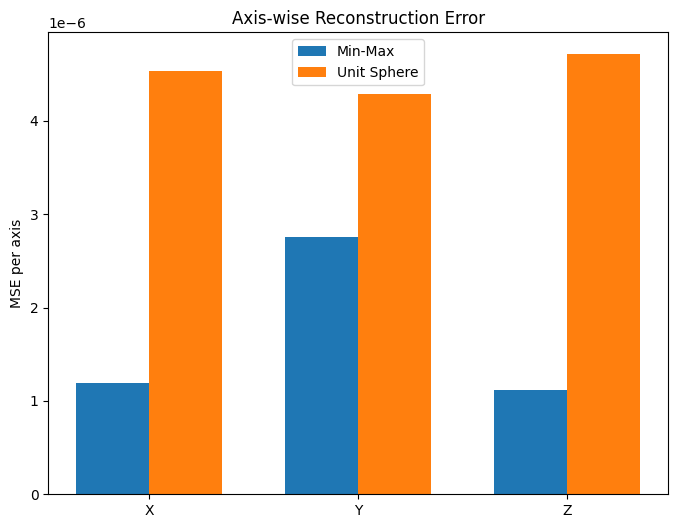

In [33]:
def plot_axis_errors(results_a, label_a, results_b, label_b):
    x = np.arange(3)
    width = 0.35
    plt.bar(x - width/2, results_a['errors']['MSE_axis'], width, label=label_a)
    plt.bar(x + width/2, results_b['errors']['MSE_axis'], width, label=label_b)
    plt.xticks(x, ['X', 'Y', 'Z'])
    plt.ylabel("MSE per axis")
    plt.title("Axis-wise Reconstruction Error")
    plt.legend()
    plt.show()

plot_axis_errors(results_minmax, "Min-Max", results_unitsphere, "Unit Sphere")

In [35]:
print("=== Short Analysis ===")
print(f"Min-Max MSE: {results_minmax['errors']['MSE']:.8f}")
print(f"Unit-Sphere MSE: {results_unitsphere['errors']['MSE']:.8f}")
print("\nObservations:")
print("- Compare both methods: lower MSE → better structure preservation.")
print("- Min–Max often performs better for meshes with axis-aligned scales.")
print("- Unit Sphere normalization maintains relative geometry across all axes.")
print("- Quantization error increases for fine details or extreme aspect ratios.")

=== Short Analysis ===
Min-Max MSE: 0.00000169
Unit-Sphere MSE: 0.00000451

Observations:
- Compare both methods: lower MSE → better structure preservation.
- Min–Max often performs better for meshes with axis-aligned scales.
- Unit Sphere normalization maintains relative geometry across all axes.
- Quantization error increases for fine details or extreme aspect ratios.
